In [18]:
import matplotlib.pyplot as plt


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.2f}".format)


In [20]:
risk_path = "risk_levels_by_group.xlsx"
model_path = "Model.xlsx"

risk_xl = pd.ExcelFile(risk_path)
model_xl = pd.ExcelFile(model_path)

print("Các sheet trong risk_levels_by_group.xlsx:")
print(risk_xl.sheet_names)

print("\nCác sheet trong Model.xlsx:")
print(model_xl.sheet_names)


Các sheet trong risk_levels_by_group.xlsx:
['1Q_XGB', '2Q_XGB', '1Q_LGBM', '2Q_LGBM', '1Q_MC_60', '2Q_MC_60', '1Q_MC_250', '2Q_MC_250', '1Q_MC_FULL', '2Q_MC_FULL']

Các sheet trong Model.xlsx:
['Var', 'RS']


In [21]:
# Sheet chuẩn (benchmark)
df_var = model_xl.parse("Var")

# Đảm bảo tên cột thống nhất
df_var = df_var.rename(columns={
    "Breakeven_price": "Breakeven_price",
    "0% at Risk": "AtRisk_0"
})

df_var.head()


,Ticker,Group,Breakeven_price,AtRisk_0
0,BAB,C,8040,5720
1,ACB,A,19300,13650
2,BID,A,28850,20650
3,NVB,C,8440,5460
4,CTG,B,37750,27800


In [22]:
model_sheets = [
    "1Q_XGB",
    "1Q_LGBM",
    "1Q_MC_60",
    "1Q_MC_250",
    "1Q_MC_FULL",
]


In [23]:
def prepare_model_vs_var(risk_xl, sheet_name, df_var):
    """
    Trả về:
      df_merged: DataFrame đã merge + các cột sai số
      metrics: dict gồm MAE, RMSE,... cho model này
    """
    df_model = risk_xl.parse(sheet_name)
    df_model = df_model.rename(columns={
        "Breakeven_price": "Breakeven_price",
        "0% at Risk": "AtRisk_0"
    })
    
    # Merge theo Ticker (inner để chỉ giữ mã có ở cả 2 bên)
    df = pd.merge(
        df_var,
        df_model,
        on="Ticker",
        suffixes=("_var", f"_{sheet_name}"),
        how="inner"
    )
    
    # Nếu có Group ở 2 bên, bạn có thể kiểm tra consistency:
    if "Group_var" in df.columns and "Group_" + sheet_name in df.columns:
        mismatch = (df["Group_var"] != df[f"Group_{sheet_name}"]).sum()
        print(f"[{sheet_name}] Số mã khác Group giữa Var và {sheet_name}: {mismatch}")
    
    # Sai số Breakeven_price
    df[f"diff_be_{sheet_name}"] = df[f"Breakeven_price_{sheet_name}"] - df["Breakeven_price_var"]
    df[f"abs_diff_be_{sheet_name}"] = df[f"diff_be_{sheet_name}"].abs()
    df[f"pct_diff_be_{sheet_name}"] = df[f"diff_be_{sheet_name}"] / df["Breakeven_price_var"]
    
    # Sai số 0% at Risk
    df[f"diff_ar_{sheet_name}"] = df[f"AtRisk_0_{sheet_name}"] - df["AtRisk_0_var"]
    df[f"abs_diff_ar_{sheet_name}"] = df[f"diff_ar_{sheet_name}"].abs()
    df[f"pct_diff_ar_{sheet_name}"] = df[f"diff_ar_{sheet_name}"] / df["AtRisk_0_var"]
    
    # Tính metrics tổng hợp
    def mae(x): return x.abs().mean()
    def rmse(x): return np.sqrt((x**2).mean())
    
    metrics = {
        "model": sheet_name,
        "n_common_tickers": len(df),
        "MAE_be": mae(df[f"diff_be_{sheet_name}"]),
        "RMSE_be": rmse(df[f"diff_be_{sheet_name}"]),
        "MAE_ar": mae(df[f"diff_ar_{sheet_name}"]),
        "RMSE_ar": rmse(df[f"diff_ar_{sheet_name}"]),
        "corr_be": df["Breakeven_price_var"].corr(df[f"Breakeven_price_{sheet_name}"]),
        "corr_ar": df["AtRisk_0_var"].corr(df[f"AtRisk_0_{sheet_name}"]),
    }
    
    return df, metrics


In [24]:
all_metrics = []
merged_by_model = {}  # để lưu df_merged từng model

for sheet in model_sheets:
    print(f"Đang xử lý mô hình: {sheet}")
    df_merged, metrics = prepare_model_vs_var(risk_xl, sheet, df_var)
    merged_by_model[sheet] = df_merged
    all_metrics.append(metrics)

df_metrics = pd.DataFrame(all_metrics)
df_metrics


Đang xử lý mô hình: 1Q_XGB
[1Q_XGB] Số mã khác Group giữa Var và 1Q_XGB: 480
Đang xử lý mô hình: 1Q_LGBM
[1Q_LGBM] Số mã khác Group giữa Var và 1Q_LGBM: 480
Đang xử lý mô hình: 1Q_MC_60
[1Q_MC_60] Số mã khác Group giữa Var và 1Q_MC_60: 480
Đang xử lý mô hình: 1Q_MC_250
[1Q_MC_250] Số mã khác Group giữa Var và 1Q_MC_250: 480
Đang xử lý mô hình: 1Q_MC_FULL
[1Q_MC_FULL] Số mã khác Group giữa Var và 1Q_MC_FULL: 480


,model,n_common_tickers,MAE_be,RMSE_be,MAE_ar,RMSE_ar,corr_be,corr_ar
0,1Q_XGB,743,"2,619.99","6,540.60","3,629.22","8,965.87",0.96,0.87
1,1Q_LGBM,743,"2,849.58","6,877.43","3,299.00","8,726.71",0.96,0.87
2,1Q_MC_60,743,"2,303.00","5,221.09","3,446.31","6,393.78",0.97,0.96
3,1Q_MC_250,743,"1,568.42","3,806.18","2,574.29","4,169.09",0.99,0.99
4,1Q_MC_FULL,743,"1,858.26","4,682.10","2,656.83","5,683.14",0.98,0.95


In [25]:
# Chuẩn hóa điểm (0 = tốt nhất)
df_tmp = df_metrics.copy()

for col in ["MAE_be", "MAE_ar", "RMSE_be", "RMSE_ar"]:
    df_tmp[col + "_norm"] = (df_tmp[col] - df_tmp[col].min()) / (df_tmp[col].max() - df_tmp[col].min())

# Score đơn giản = trung bình 4 chỉ số chuẩn hóa
df_tmp["score_overall"] = df_tmp[[c for c in df_tmp.columns if c.endswith("_norm")]].mean(axis=1)

df_rank = df_tmp.sort_values("score_overall")
df_rank[["model", "score_overall", "MAE_be", "MAE_ar", "RMSE_be", "RMSE_ar", "corr_be", "corr_ar"]]


,model,score_overall,MAE_be,MAE_ar,RMSE_be,RMSE_ar,corr_be,corr_ar
3,1Q_MC_250,0.00,"1,568.42","2,574.29","3,806.18","4,169.09",0.99,0.99
4,1Q_MC_FULL,0.23,"1,858.26","2,656.83","4,682.10","5,683.14",0.98,0.95
2,1Q_MC_60,0.58,"2,303.00","3,446.31","5,221.09","6,393.78",0.97,0.96
1,1Q_LGBM,0.91,"2,849.58","3,299.00","6,877.43","8,726.71",0.96,0.87
0,1Q_XGB,0.93,"2,619.99","3,629.22","6,540.60","8,965.87",0.96,0.87


In [26]:
best_model = df_rank.iloc[0]["model"]
best_model


'1Q_MC_250'

In [70]:
df_best = merged_by_model[best_model].copy()

cols_show = [
    "Ticker",
    "Group_var" if "Group_var" in df_best.columns else "Group",
    "Breakeven_price_var",
    f"Breakeven_price_{best_model}",
    f"diff_be_{best_model}",
    f"abs_diff_be_{best_model}",
    "AtRisk_0_var",
    f"AtRisk_0_{best_model}",
    f"diff_ar_{best_model}",
    f"abs_diff_ar_{best_model}",
]

df_best[cols_show].head(10)


,Ticker,Group_var,Breakeven_price_var,Breakeven_price_1Q_MC_250,diff_be_1Q_MC_250,abs_diff_be_1Q_MC_250,AtRisk_0_var,AtRisk_0_1Q_MC_250,diff_ar_1Q_MC_250,abs_diff_ar_1Q_MC_250
0,BAB,C,8040,"7,807.08",-232.92,232.92,5720,"6,062.42",342.42,342.42
1,ACB,A,19300,"17,261.17","-2,038.83","2,038.83",13650,"13,219.11",-430.89,430.89
2,BID,A,28850,"24,736.62","-4,113.38","4,113.38",20650,"19,530.54","-1,119.46","1,119.46"
3,NVB,C,8440,"6,898.27","-1,541.73","1,541.73",5460,"5,601.68",141.68,141.68
4,CTG,B,37750,"32,995.77","-4,754.23","4,754.23",27800,"26,723.48","-1,076.52","1,076.52"
5,SHB,C,11850,"9,777.37","-2,072.63","2,072.63",9090,"7,356.93","-1,733.07","1,733.07"
6,EIB,C,13400,"13,056.06",-343.94,343.94,8820,"9,827.91","1,007.91","1,007.91"
7,AAV,B,4060,"3,418.55",-641.45,641.45,2420,"2,420.41",0.41,0.41
8,HDB,C,21950,"18,452.73","-3,497.27","3,497.27",15700,"13,060.07","-2,639.93","2,639.93"
9,ACM,D,170,107.76,-62.24,62.24,170,47.24,-122.76,122.76


In [71]:
tickers = ["VPL", "DIG", "DXG", "SJS", "VPI", "PDR"]

df_check = df_best[df_best["Ticker"].isin(tickers)].copy()

cols_show = [
    "Ticker",
    "Group_var" if "Group_var" in df_best.columns else "Group",
    "Breakeven_price_var",
    f"Breakeven_price_{best_model}",
    f"diff_be_{best_model}",
    f"abs_diff_be_{best_model}",
    "AtRisk_0_var",
    f"AtRisk_0_{best_model}",
    f"diff_ar_{best_model}",
    f"abs_diff_ar_{best_model}",
]

df_check[cols_show]


,Ticker,Group_var,Breakeven_price_var,Breakeven_price_1Q_MC_250,diff_be_1Q_MC_250,abs_diff_be_1Q_MC_250,AtRisk_0_var,AtRisk_0_1Q_MC_250,diff_ar_1Q_MC_250,abs_diff_ar_1Q_MC_250
171,DIG,C,9060,"11,414.78","2,354.78","2,354.78",4890,"8,153.61","3,263.61","3,263.61"
200,DXG,A,13250,"10,634.03","-2,615.97","2,615.97",7760,"7,645.57",-114.43,114.43
448,PDR,B,11400,"11,084.26",-315.74,315.74,5450,"8,974.53","3,524.53","3,524.53"
550,SJS,B,30450,"32,500.04","2,050.04","2,050.04",15600,"23,069.98","7,469.98","7,469.98"
699,VPI,D,25700,"37,706.49","12,006.49","12,006.49",25700,"30,935.22","5,235.22","5,235.22"


In [72]:
if "Group_var" in df_best.columns:
    group_col = "Group_var"
elif "Group" in df_best.columns:
    group_col = "Group"
else:
    group_col = None

if group_col:
    group_stats = df_best.groupby(group_col).agg({
        f"abs_diff_be_{best_model}": "mean",
        f"abs_diff_ar_{best_model}": "mean"
    }).rename(columns={
        f"abs_diff_be_{best_model}": "MAE_be_by_group",
        f"abs_diff_ar_{best_model}": "MAE_ar_by_group"
    })
    group_stats
else:
    print("Không tìm thấy cột Group để nhóm.")


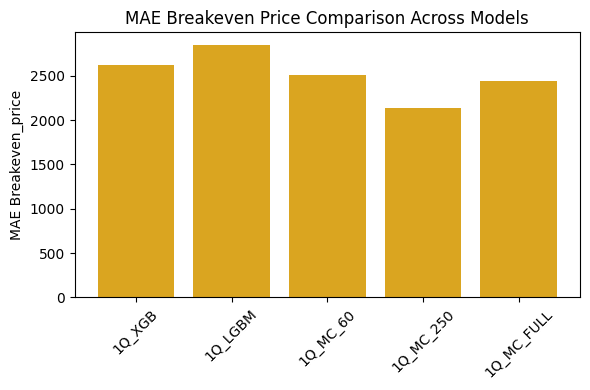

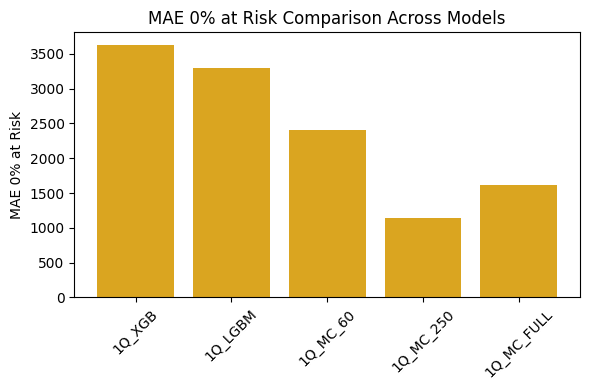

In [73]:
plt.figure(figsize=(6, 4))
plt.bar(df_metrics["model"], df_metrics["MAE_be"], color="goldenrod")
plt.xticks(rotation=45)
plt.ylabel("MAE Breakeven_price")
plt.title("MAE Breakeven Price Comparison Across Models")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(df_metrics["model"], df_metrics["MAE_ar"], color="goldenrod")
plt.xticks(rotation=45)
plt.ylabel("MAE 0% at Risk")
plt.title("MAE 0% at Risk Comparison Across Models")
plt.tight_layout()
plt.show()


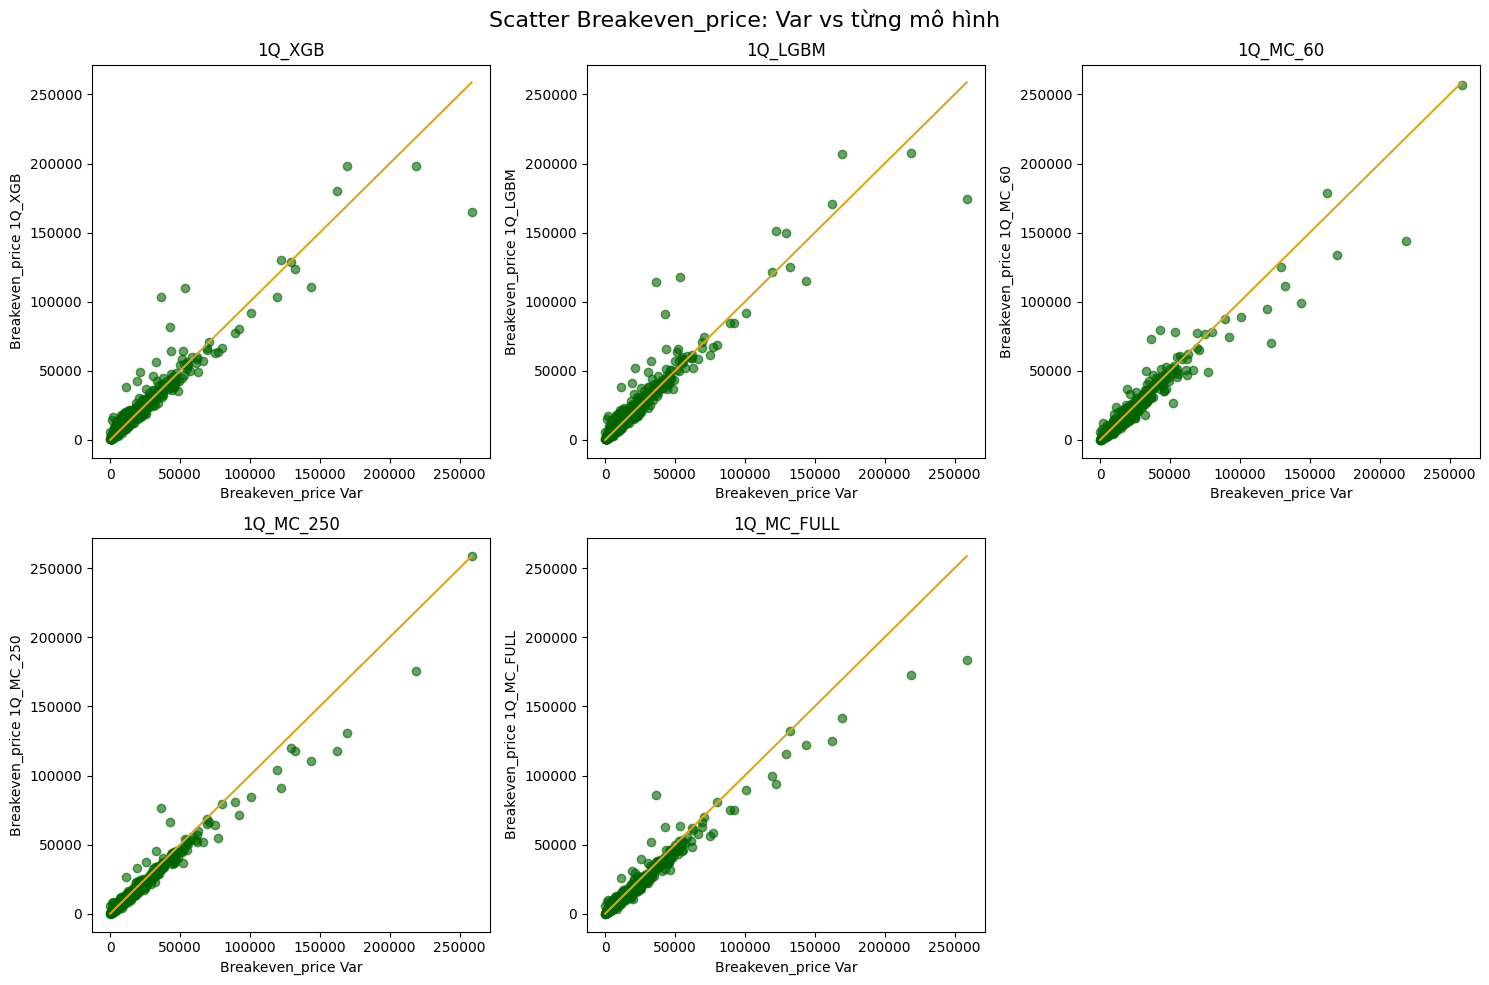

In [81]:
import matplotlib.pyplot as plt

# Tạo figure với 2 hàng, 3 cột (dư một ô trống)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # chuyển về list 1 chiều cho dễ lặp

for i, model in enumerate(model_sheets):
    ax = axes[i]
    df_m = merged_by_model[model]

    x = df_m["Breakeven_price_var"]
    y = df_m[f"Breakeven_price_{model}"]

    # Scatter
    ax.scatter(x, y, alpha=0.6,  color="#006400")

    # Vẽ đường y = x cho subplot này
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], color="goldenrod")

    ax.set_xlabel("Breakeven_price Var")
    ax.set_ylabel(f"Breakeven_price {model}")
    ax.set_title(model)

# Ẩn ô subplot thừa (ô thứ 6)
if len(model_sheets) < len(axes):
    for j in range(len(model_sheets), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle("Scatter Breakeven_price: Var vs từng mô hình", fontsize=16)
plt.tight_layout()
plt.show()


In [75]:
df_best = merged_by_model[best_model].copy()

cols_show = [
    "Ticker",
    "Group_var" if "Group_var" in df_best.columns else "Group",
    "Breakeven_price_var",
    f"Breakeven_price_{best_model}",
    f"diff_be_{best_model}",
    f"abs_diff_be_{best_model}",
    "AtRisk_0_var",
    f"AtRisk_0_{best_model}",
    f"diff_ar_{best_model}",
    f"abs_diff_ar_{best_model}",
]

df_best[cols_show].head(10)


,Ticker,Group_var,Breakeven_price_var,Breakeven_price_1Q_MC_250,diff_be_1Q_MC_250,abs_diff_be_1Q_MC_250,AtRisk_0_var,AtRisk_0_1Q_MC_250,diff_ar_1Q_MC_250,abs_diff_ar_1Q_MC_250
0,BAB,C,8040,"7,807.08",-232.92,232.92,5720,"6,062.42",342.42,342.42
1,ACB,A,19300,"17,261.17","-2,038.83","2,038.83",13650,"13,219.11",-430.89,430.89
2,BID,A,28850,"24,736.62","-4,113.38","4,113.38",20650,"19,530.54","-1,119.46","1,119.46"
3,NVB,C,8440,"6,898.27","-1,541.73","1,541.73",5460,"5,601.68",141.68,141.68
4,CTG,B,37750,"32,995.77","-4,754.23","4,754.23",27800,"26,723.48","-1,076.52","1,076.52"
5,SHB,C,11850,"9,777.37","-2,072.63","2,072.63",9090,"7,356.93","-1,733.07","1,733.07"
6,EIB,C,13400,"13,056.06",-343.94,343.94,8820,"9,827.91","1,007.91","1,007.91"
7,AAV,B,4060,"3,418.55",-641.45,641.45,2420,"2,420.41",0.41,0.41
8,HDB,C,21950,"18,452.73","-3,497.27","3,497.27",15700,"13,060.07","-2,639.93","2,639.93"
9,ACM,D,170,107.76,-62.24,62.24,170,47.24,-122.76,122.76


In [76]:
import pandas as pd

# --- 1. Load file ---
risk_path = "risk_levels_by_group.xlsx"
model_path = "Model.xlsx"

risk_xl = pd.ExcelFile(risk_path)
model_xl = pd.ExcelFile(model_path)

# Sheet chuẩn (benchmark)
df_var = model_xl.parse("Var")

# Đảm bảo tên cột đúng
df_var = df_var.rename(columns={
    "Ticker": "Ticker",
    "Group": "Group"
})

model_sheets = [
    "1Q_XGB",
    "1Q_LGBM",
    "1Q_MC_60",
    "1Q_MC_250",
    "1Q_MC_FULL",
]

results = []

for sheet in model_sheets:
    df_model = risk_xl.parse(sheet)
    df_model = df_model.rename(columns={
        "Ticker": "Ticker",
        "Group": "Group"
    })
    
    # --- 2. Trùng Ticker (chỉ xét mã) ---
    tickers_var = set(df_var["Ticker"].unique())
    tickers_model = set(df_model["Ticker"].unique())
    
    common_tickers = tickers_var & tickers_model
    n_common_tickers = len(common_tickers)
    
    # --- 3. Trùng cả Ticker + Group ---
    # Tạo key ghép (Ticker, Group) cho 2 bên
    var_pairs = set(zip(df_var["Ticker"], df_var["Group"]))
    model_pairs = set(zip(df_model["Ticker"], df_model["Group"]))
    
    common_pairs = var_pairs & model_pairs
    n_common_pairs = len(common_pairs)
    
    # --- 4. Đếm số mã cùng Ticker nhưng Group khác ---
    # Merge theo Ticker, rồi so Group
    df_merge_ticker = pd.merge(
        df_var[["Ticker", "Group"]],
        df_model[["Ticker", "Group"]],
        on="Ticker",
        suffixes=("_var", "_model"),
        how="inner"
    )
    # số mã có trùng ticker nhưng group khác
    n_ticker_same_group_diff = (df_merge_ticker["Group_var"] != df_merge_ticker["Group_model"]).sum()
    
    results.append({
        "model": sheet,
        "n_ticker_in_Var": len(tickers_var),
        "n_ticker_in_model": len(tickers_model),
        "n_common_ticker": n_common_tickers,
        "n_common_ticker_group": n_common_pairs,
        "n_ticker_same_but_group_diff": n_ticker_same_group_diff,
    })

df_overlap = pd.DataFrame(results)
df_overlap


,model,n_ticker_in_Var,n_ticker_in_model,n_common_ticker,n_common_ticker_group,n_ticker_same_but_group_diff
0,1Q_XGB,741,1686,741,262,480
1,1Q_LGBM,741,1686,741,262,480
2,1Q_MC_60,741,1684,741,262,480
3,1Q_MC_250,741,1684,741,262,480
4,1Q_MC_FULL,741,1684,741,262,480


In [77]:
import pandas as pd

# --- 1. Load file ---
risk_path = "risk_levels_by_group.xlsx"
model_path = "Model.xlsx"

risk_xl = pd.ExcelFile(risk_path)
model_xl = pd.ExcelFile(model_path)

df_var = model_xl.parse("Var")
df_var = df_var.rename(columns={"Ticker": "Ticker", "Group": "Group"})

model_sheets = [
    "1Q_XGB",
    "1Q_LGBM",
    "1Q_MC_60",
    "1Q_MC_250",
    "1Q_MC_FULL",
]

all_wrong_groups = {}  # lưu lại để bạn xem sau

for sheet in model_sheets:
    print(f"\n==============================")
    print(f"🔍 MÔ HÌNH: {sheet}")
    print(f"==============================")
    
    df_model = risk_xl.parse(sheet)
    df_model = df_model.rename(columns={"Ticker": "Ticker", "Group": "Group"})
    
    # Merge theo Ticker để so Group
    df_merge = pd.merge(
        df_var[["Ticker", "Group"]],
        df_model[["Ticker", "Group"]],
        on="Ticker",
        suffixes=("_var", "_model"),
        how="inner"
    )
    
    # Lọc mã có Group khác nhau
    df_wrong = df_merge[df_merge["Group_var"] != df_merge["Group_model"]].copy()
    
    if df_wrong.empty:
        print("✅ Không có mã nào bị lệch Group.")
    else:
        print(f"❌ Số mã lệch Group: {len(df_wrong)}")
        print(df_wrong)
    
    all_wrong_groups[sheet] = df_wrong



🔍 MÔ HÌNH: 1Q_XGB
❌ Số mã lệch Group: 480
    Ticker        Group_var Group_model
0      BAB                C           B
2      BID                A           B
5      SHB                C           B
6      EIB                C           B
8      HDB                C           A
..     ...              ...         ...
738    PVP                A           B
739    SIP                A           B
740    TCI                C           B
741    GEE  Not enough data           B
742    SBG  Not enough data           B

[480 rows x 3 columns]

🔍 MÔ HÌNH: 1Q_LGBM
❌ Số mã lệch Group: 480
    Ticker        Group_var Group_model
0      BAB                C           B
2      BID                A           B
5      SHB                C           B
6      EIB                C           B
8      HDB                C           A
..     ...              ...         ...
738    PVP                A           B
739    SIP                A           B
740    TCI                C           B
741    GE

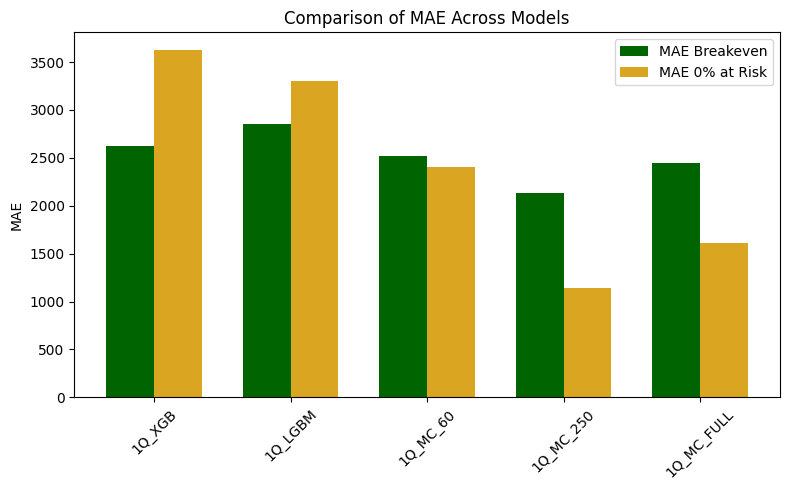

In [78]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(df_metrics["model"]))  # positions for models
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Bar plots with colors
ax.bar(x - width/2, df_metrics["MAE_be"], width, label="MAE Breakeven", color="#006400")  # dark green
ax.bar(x + width/2, df_metrics["MAE_ar"], width, label="MAE 0% at Risk", color="goldenrod")  # dark yellow

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(df_metrics["model"], rotation=45)
ax.set_ylabel("MAE")
ax.set_title("Comparison of MAE Across Models")
ax.legend()
plt.tight_layout()
plt.show()


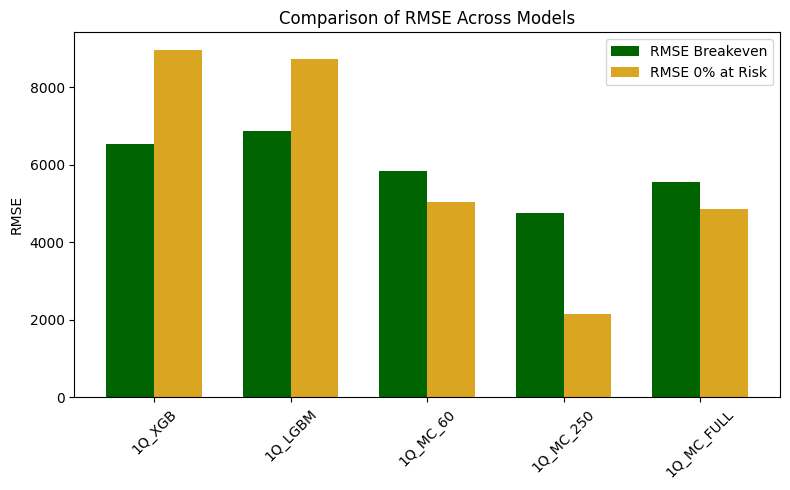

In [79]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df_metrics["model"]))  # positions for models
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Bar plots
ax.bar(x - width/2, df_metrics["RMSE_be"], width, label="RMSE Breakeven", color="#006400")  # dark green
ax.bar(x + width/2, df_metrics["RMSE_ar"], width, label="RMSE 0% at Risk", color="goldenrod")  # dark yellow

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(df_metrics["model"], rotation=45)
ax.set_ylabel("RMSE")
ax.set_title("Comparison of RMSE Across Models")
ax.legend()
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd

risk_path = "risk_levels_by_group.xlsx"
model_path = "Model.xlsx"

risk_xl = pd.ExcelFile(risk_path)
model_xl = pd.ExcelFile(model_path)

# 1. Đọc 2 sheet
df_rs = model_xl.parse("RS").rename(columns={"Ticker": "Ticker", "Group": "Group_rs"})
df_mc250 = risk_xl.parse("1Q_MC_250").rename(columns={"Ticker": "Ticker", "Group": "Group_mc"})

# 2. Merge theo Ticker
df_cmp = pd.merge(
    df_rs[["Ticker", "Group_rs"]],
    df_mc250[["Ticker", "Group_mc"]],
    on="Ticker",
    how="inner"
)

# 3. Hàm chuyển rating RS về bậc A/B/C theo chữ cái đầu
def to_band(g):
    if not isinstance(g, str):
        return None
    g = g.strip().upper()
    if g.startswith("A"):
        return "A"
    if g.startswith("B"):
        return "B"
    if g.startswith("C"):
        return "C"
    return None  # phòng khi có loại khác

df_cmp["band_rs"] = df_cmp["Group_rs"].apply(to_band)
df_cmp["band_mc"] = df_cmp["Group_mc"].apply(to_band)

# 4. Map A/B/C -> 0/1/2 để đo độ lệch bậc
band_order = {"A": 0, "B": 1, "C": 2}

df_cmp["band_rs_idx"] = df_cmp["band_rs"].map(band_order)
df_cmp["band_mc_idx"] = df_cmp["band_mc"].map(band_order)

df_cmp["band_diff"] = df_cmp["band_rs_idx"] - df_cmp["band_mc_idx"]
df_cmp["abs_band_diff"] = df_cmp["band_diff"].abs()

# 5. Phân loại mức độ "trùng" / "gần" / "lệch xa"
def classify(row):
    d = row["abs_band_diff"]
    if pd.isna(d):
        return "unknown"
    if d == 0:
        return "exact"   # cùng bậc (A-A, B-B, C-C)
    elif d == 1:
        return "near"    # lệch 1 bậc (A-B, B-C, ...)
    else:
        return "far"     # lệch >=2 bậc (A-C hoặc C-A)

df_cmp["match_level"] = df_cmp.apply(classify, axis=1)

# 6. Thống kê
total = len(df_cmp)
count_exact = (df_cmp["match_level"] == "exact").sum()
count_near  = (df_cmp["match_level"] == "near").sum()
count_far   = (df_cmp["match_level"] == "far").sum()

print("Tổng số mã trùng Ticker giữa RS và 1Q_MC_250:", total)
print(" - Trùng đúng bậc (exact A-A/B-B/C-C):", count_exact)
print(" - Gần (near, lệch 1 bậc, ví dụ C vs BB):", count_near)
print(" - Lệch xa (far, lệch >= 2 bậc, ví dụ A vs C):", count_far)

# 7. Lọc riêng bảng các trường hợp "lệch xa" (chỉ nhóm này mới bị coi là lệch rating)
df_far = df_cmp[df_cmp["match_level"] == "far"].copy()
print("\nCác mã bị lệch xa (A vs C hoặc C vs A):")
df_far[["Ticker", "Group_rs", "Group_mc", "band_rs", "band_mc", "match_level"]]


Tổng số mã trùng Ticker giữa RS và 1Q_MC_250: 1591
 - Trùng đúng bậc (exact A-A/B-B/C-C): 756
 - Gần (near, lệch 1 bậc, ví dụ C vs BB): 324
 - Lệch xa (far, lệch >= 2 bậc, ví dụ A vs C): 0

Các mã bị lệch xa (A vs C hoặc C vs A):


,Ticker,Group_rs,Group_mc,band_rs,band_mc,match_level


In [96]:
import pandas as pd

risk_path = "risk_levels_by_group.xlsx"
model_path = "Model.xlsx"

risk_xl = pd.ExcelFile(risk_path)
model_xl = pd.ExcelFile(model_path)

# 1. Đọc 2 sheet
df_rs = model_xl.parse("RS").rename(columns={"Ticker": "Ticker", "Group": "Group_rs"})
df_mc250 = risk_xl.parse("1Q_MC_250").rename(columns={"Ticker": "Ticker", "Group": "Group_mc"})

# 2. Merge theo Ticker
df_cmp = pd.merge(
    df_rs[["Ticker", "Group_rs"]],
    df_mc250[["Ticker", "Group_mc"]],
    on="Ticker",
    how="inner"
)

# 3. Đưa RS về bậc A/B/C dựa trên chữ cái đầu
def to_band(g):
    if not isinstance(g, str):
        return None
    g = g.strip().upper()
    if g.startswith("A"):
        return "A"
    if g.startswith("B"):
        return "B"
    if g.startswith("C"):
        return "C"
    return None

df_cmp["band_rs"] = df_cmp["Group_rs"].apply(to_band)
df_cmp["band_mc"] = df_cmp["Group_mc"].apply(to_band)

# 4. Map A/B/C -> 0/1/2
band_order = {"A": 0, "B": 1, "C": 2}
df_cmp["band_rs_idx"] = df_cmp["band_rs"].map(band_order)
df_cmp["band_mc_idx"] = df_cmp["band_mc"].map(band_order)

df_cmp["band_diff"] = df_cmp["band_rs_idx"] - df_cmp["band_mc_idx"]
df_cmp["abs_band_diff"] = df_cmp["band_diff"].abs()

# 5. Phân loại mức độ lệch
def classify(row):
    d = row["abs_band_diff"]
    if pd.isna(d):
        return "unknown"
    if d == 0:
        return "exact"   # A-A / B-B / C-C
    elif d == 1:
        return "near"    # A-B / B-A / B-C / C-B
    else:
        return "far"     # A-C / C-A (lệch xa)

df_cmp["match_level"] = df_cmp.apply(classify, axis=1)

df_cmp.head()


,Ticker,Group_rs,Group_mc,band_rs,band_mc,band_rs_idx,band_mc_idx,band_diff,abs_band_diff,match_level
0,AAA,BB,B,B,B,1.00,1.00,0.00,0.00,exact
1,AAM,BB,B,B,B,1.00,1.00,0.00,0.00,exact
2,AAT,BBB,B,B,B,1.00,1.00,0.00,0.00,exact
3,ABR,BBB,B,B,B,1.00,1.00,0.00,0.00,exact
4,ABS,CCC,B,C,B,2.00,1.00,1.00,1.00,near


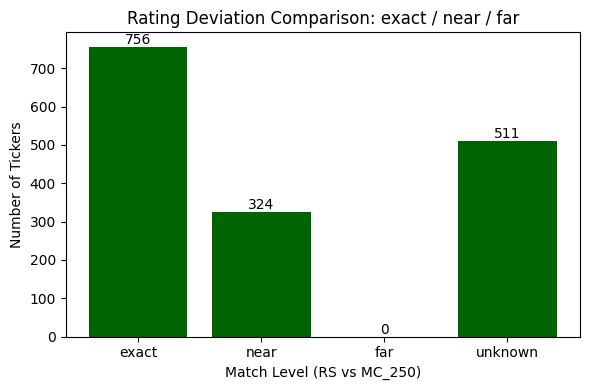

In [99]:
import matplotlib.pyplot as plt

# Count categories and fill missing ones with 0
counts = (
    df_cmp["match_level"]
    .value_counts()
    .reindex(["exact", "near", "far", "unknown"])
    .fillna(0)
)

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color="#006400")

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Match Level (RS vs MC_250)")
plt.ylabel("Number of Tickers")
plt.title("Rating Deviation Comparison: exact / near / far")
plt.tight_layout()
plt.show()


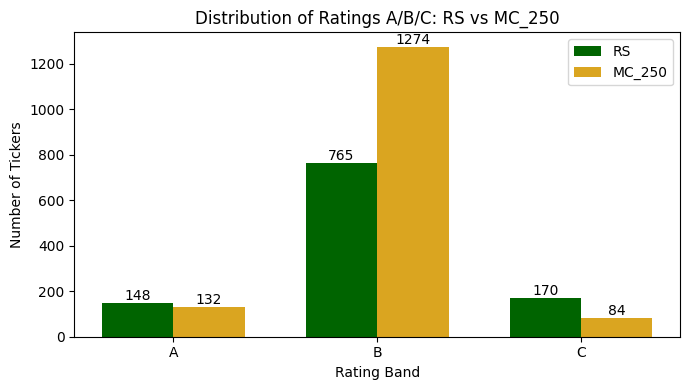

In [103]:
import numpy as np
import matplotlib.pyplot as plt

bands = ["A", "B", "C"]

# Count bands and fill missing values with 0
rs_counts = df_cmp["band_rs"].value_counts().reindex(bands).fillna(0)
mc_counts = df_cmp["band_mc"].value_counts().reindex(bands).fillna(0)

x = np.arange(len(bands))
width = 0.35

plt.figure(figsize=(7, 4))

bars_rs = plt.bar(x - width/2, rs_counts.values, width, label="RS", color="#006400")
bars_mc = plt.bar(x + width/2, mc_counts.values, width, label="MC_250", color="goldenrod")

# Add value labels
for bar in list(bars_rs) + list(bars_mc):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(x, bands)
plt.xlabel("Rating Band")
plt.ylabel("Number of Tickers")
plt.title("Distribution of Ratings A/B/C: RS vs MC_250")
plt.legend()
plt.tight_layout()
plt.show()


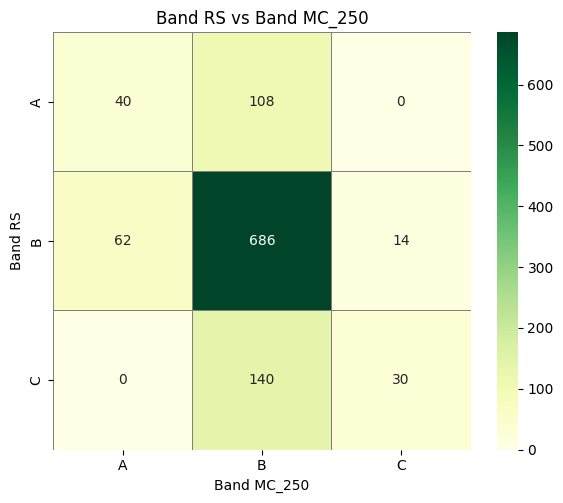

In [106]:
import seaborn as sns

ct = pd.crosstab(df_cmp["band_rs"], df_cmp["band_mc"]).reindex(index=["A","B","C"], columns=["A","B","C"]).fillna(0).astype(int)

plt.figure(figsize=(6,5))
sns.heatmap(ct, annot=True, fmt="d", cmap="YlGn", cbar=True, linewidths=0.5, linecolor="gray", square=True)
plt.xlabel("Band MC_250")
plt.ylabel("Band RS")
plt.title("Band RS vs Band MC_250")
plt.tight_layout()
plt.show()
